<a href="https://colab.research.google.com/github/luyuzhe111/BiT-SimSiam/blob/master/INR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
root_dir = 'drive/MyDrive/BioMedSupRes'
os.chdir(root_dir)

In [7]:
data = './data/calibrationSpectrum.tif'

In [8]:
import skimage.io as skio

In [9]:
img_stack = skio.imread(data, plugin="tifffile")

In [10]:
img_stack.shape

(330, 620, 2560)

In [11]:
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

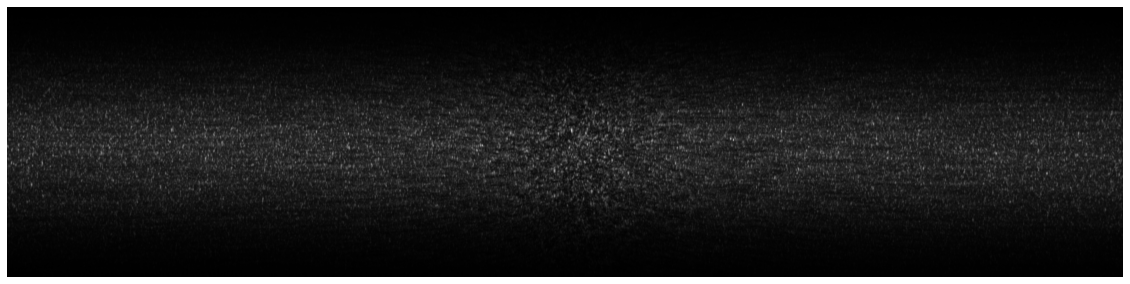

In [12]:
plt.figure(figsize=(20, 12))
plt.imshow(img_stack[0], cmap='gray')
plt.axis('off')
plt.show()

In [13]:
import torch
import torch.nn as nn
import numpy as np

In [52]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output

In [53]:
class MLP(nn.Module):
  def __init__(self, architecture=[2, 100, 100, 1]):
        super(MLP, self).__init__()      
        self.architecture=architecture
        arch=[]
        for i in range(1,len(architecture)-1):
            arch.append(nn.Linear(architecture[i-1], architecture[i]))
            arch.append(nn.ReLU())       
        self.hidden=nn.Sequential(*arch)
        self.regressor=nn.Linear(architecture[-2], architecture[-1])
        
  def forward(self,f):            
        z=self.hidden(f)
        out=self.regressor(z)
        return out

In [54]:
from PIL import Image
from torchvision import transforms

In [55]:
data = Image.fromarray(img_stack[0])

In [56]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
])
img = transform(data)

In [57]:
_, x_dim, y_dim = img.shape

In [58]:
x_dim, y_dim

(620, 2560)

In [59]:
x = torch.arange(x_dim)
y = torch.arange(y_dim)
mesh = torch.cartesian_prod(x, y)

normed_x = (torch.arange(x_dim) / (x_dim - 1) - 0.5) * 2
normed_y = (torch.arange(y_dim) / (y_dim - 1) - 0.5) * 2
normed_mesh = torch.cartesian_prod(normed_x, normed_y)

In [60]:
targets = img.permute(1, 2, 0).view(-1, 1)

In [61]:
targets.shape

torch.Size([1587200, 1])

In [62]:
mesh.shape[0] == x_dim * y_dim

True

In [63]:
(np.array(data)[mesh[:, 0], mesh[:, 1]].reshape(x_dim, y_dim) == np.array(data)).all()

True

In [64]:
targets.shape, mesh.shape

(torch.Size([1587200, 1]), torch.Size([1587200, 2]))

In [430]:
n_layer = 4
n_hidden = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
model =Siren(in_features=2, out_features=1, first_omega_0=1200,  hidden_features=n_hidden, hidden_layers=n_layer, outermost_linear=True).to(device)

n_epoch = 70
lr = 1e-4
batch_size = 5000
optim=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim,milestones=[15, 40, 55], gamma=0.2)
criterion = nn.MSELoss(reduction='sum').to(device)

model

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (5): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [431]:
n_coords = mesh.shape[0]

model.train()
for epoch in tqdm(range(n_epoch)):
  rand_inds = torch.randperm(n_coords, device=device)
  n_batch = int(n_coords // batch_size) + 1
  pbar = tqdm(range(n_batch), position=0, leave=True, desc=f"Epoch {epoch}")
  n_sample = 0
  loss_sum = 0
  for i in pbar:
    batch_inds = rand_inds[i * batch_size: (i+1) * batch_size]
    coords = normed_mesh[batch_inds, :].to(device)
    preds = model(coords)
    tars = targets[batch_inds, :].to(device)

    loss = criterion(preds, tars)
    
    n_sample += len(batch_inds)
    loss_sum += loss.item()

    pbar.set_postfix(loss=loss_sum/n_sample)

    optim.zero_grad()
    loss.backward()
    optim.step()
  
  scheduler.step()

100%|██████████| 70/70 [03:55<00:00,  3.37s/it]


In [432]:
model.eval()
eval_batch = 5000
n_batch = int(normed_mesh.shape[0] // eval_batch) + 1
eval_batches = []
with torch.no_grad():
  for i in range(n_batch):
    eval_batches.append(model(normed_mesh[i * eval_batch:(i+1) * eval_batch, ].to(device)).cpu())
pred_field = torch.cat(eval_batches, dim=0).reshape(x_dim, y_dim)

In [433]:
print(pred_field.mean(), targets.mean())
print(pred_field.min(), targets.min())
print(pred_field.max(), targets.max())

tensor(-0.8356) tensor(-0.8357)
tensor(-1.0115) tensor(-0.9843)
tensor(0.9646) tensor(0.9843)


In [434]:
print(f'MSE: {((pred_field.view(-1, 1) - targets) ** 2).mean()}')

MSE: 7.752462988719344e-05


In [435]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

In [442]:
def show_img_with_colorbar(arr, title, vmin=None, vmax=None):
  aspect = 20
  pad_fraction = 0.5

  plt.figure(figsize=(20, 12))

  ax = plt.gca()
  im = ax.imshow(arr, cmap='gray', vmin=vmin, vmax=vmax)
  ax.set_title(title)
  divider = make_axes_locatable(ax)
  width = axes_size.AxesY(ax, aspect=1./aspect)
  pad = axes_size.Fraction(pad_fraction, width)
  cax = divider.append_axes("right", size=width, pad=pad)
  plt.colorbar(im, cax=cax)
  plt.show()

In [443]:
gt = targets.reshape(x_dim, y_dim)

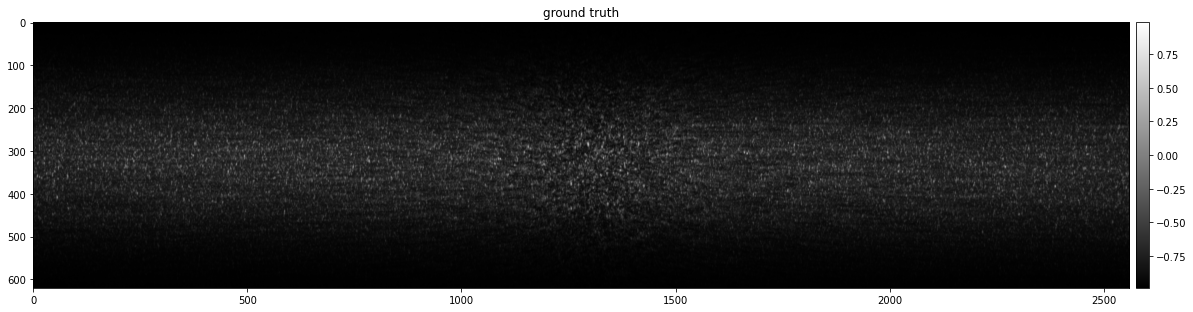

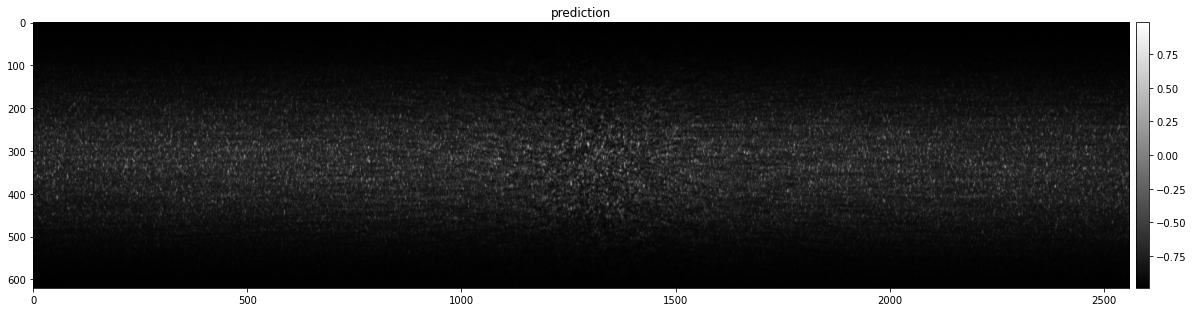

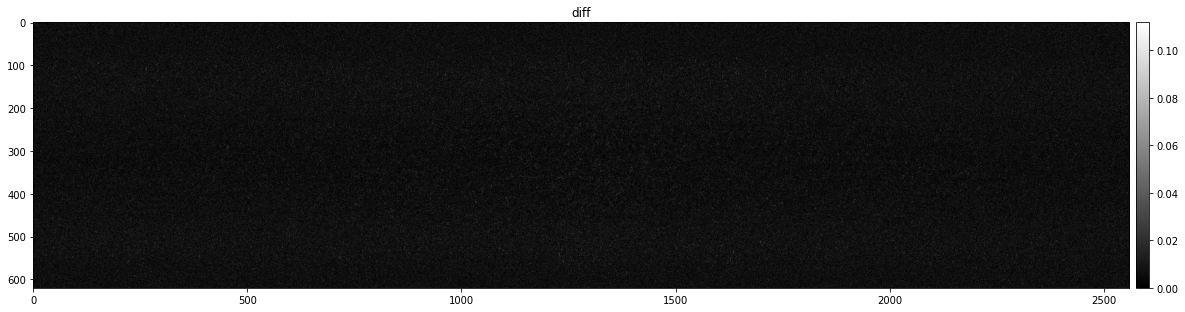

In [444]:
show_img_with_colorbar(gt, 'ground truth', vmin=targets.min(), vmax=targets.max())
show_img_with_colorbar(pred_field, 'prediction', vmin=targets.min(), vmax=targets.max())
show_img_with_colorbar(np.abs(gt - pred_field), 'diff')